# Movie Data Set Notebook 2 -- Poster Stuff

In [15]:
# General imports here.
%matplotlib inline

In [16]:
%run -i base_movie_df_generation

Cleaning up JSON objects . . . may take a while

('NaNs in movie_df?', False)


Getting the most frequent color in all posters . . . this also takes a long time


Encoding features . . .
('New Features (Genres):', (5349, 18))
('movie_df with Genres: ', (5443, 39))
. . . done


In [111]:
movie_df['revenue'] = movie_df['revenue'].apply(np.absolute)

In [112]:
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence binary variable
movie_df.head().transpose()

id,5,11,12,13,14
belongs_to_collection,0,Star Wars Collection,Finding Nemo Collection,0,0
budget,4000000,11000000,94000000,55000000,15000000
homepage,0,1,1,0,1
originally_english,1,1,1,1,1
overview,It's Ted the Bellhop's first night on the job....,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in..."
poster_path,http://image.tmdb.org/t/p/w185/eQs5hh9rxrk1m4x...,http://image.tmdb.org/t/p/w185/btTdmkgIvOi0FFi...,http://image.tmdb.org/t/p/w185/syPWyeeqzTQIxjI...,http://image.tmdb.org/t/p/w185/yE5d3BUhE8hCnkM...,http://image.tmdb.org/t/p/w185/or1MP8BZIAjqWYx...
production_companies,"[Miramax Films, A Band Apart]","[Lucasfilm, Twentieth Century Fox Film Corpora...",[Pixar Animation Studios],[Paramount Pictures],"[DreamWorks SKG, Jinks/Cohen Company]"
produced_in_us,1,1,1,1,1
release_date,12/9/1995,5/25/1977,5/30/2003,7/6/1994,9/15/1999
revenue,4.3e+06,7.75398e+08,9.40336e+08,6.77945e+08,3.56297e+08


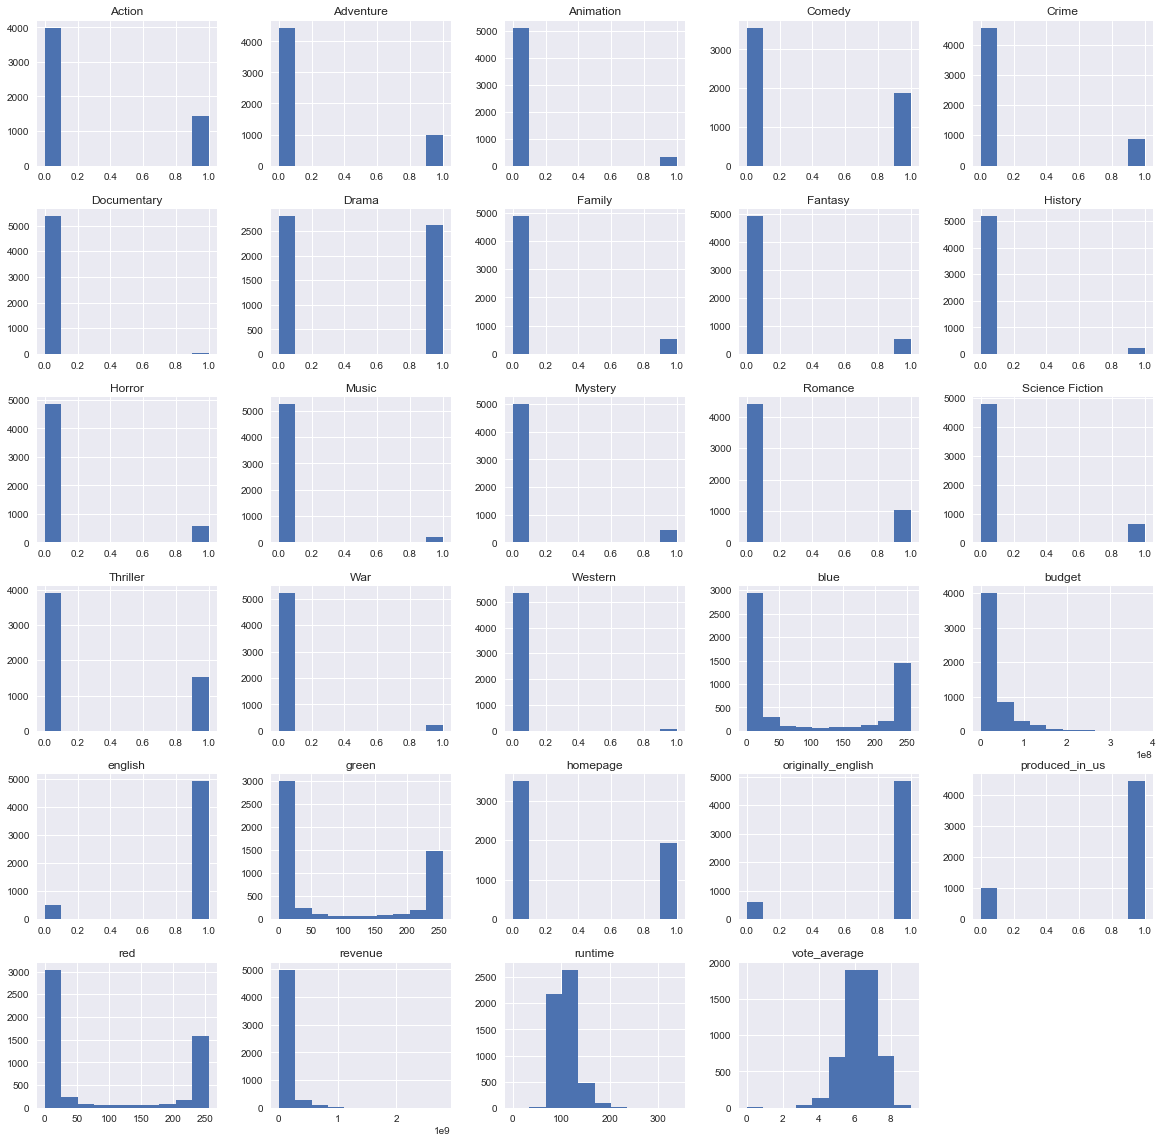

In [113]:
_ = movie_df.hist(figsize=(20,20))

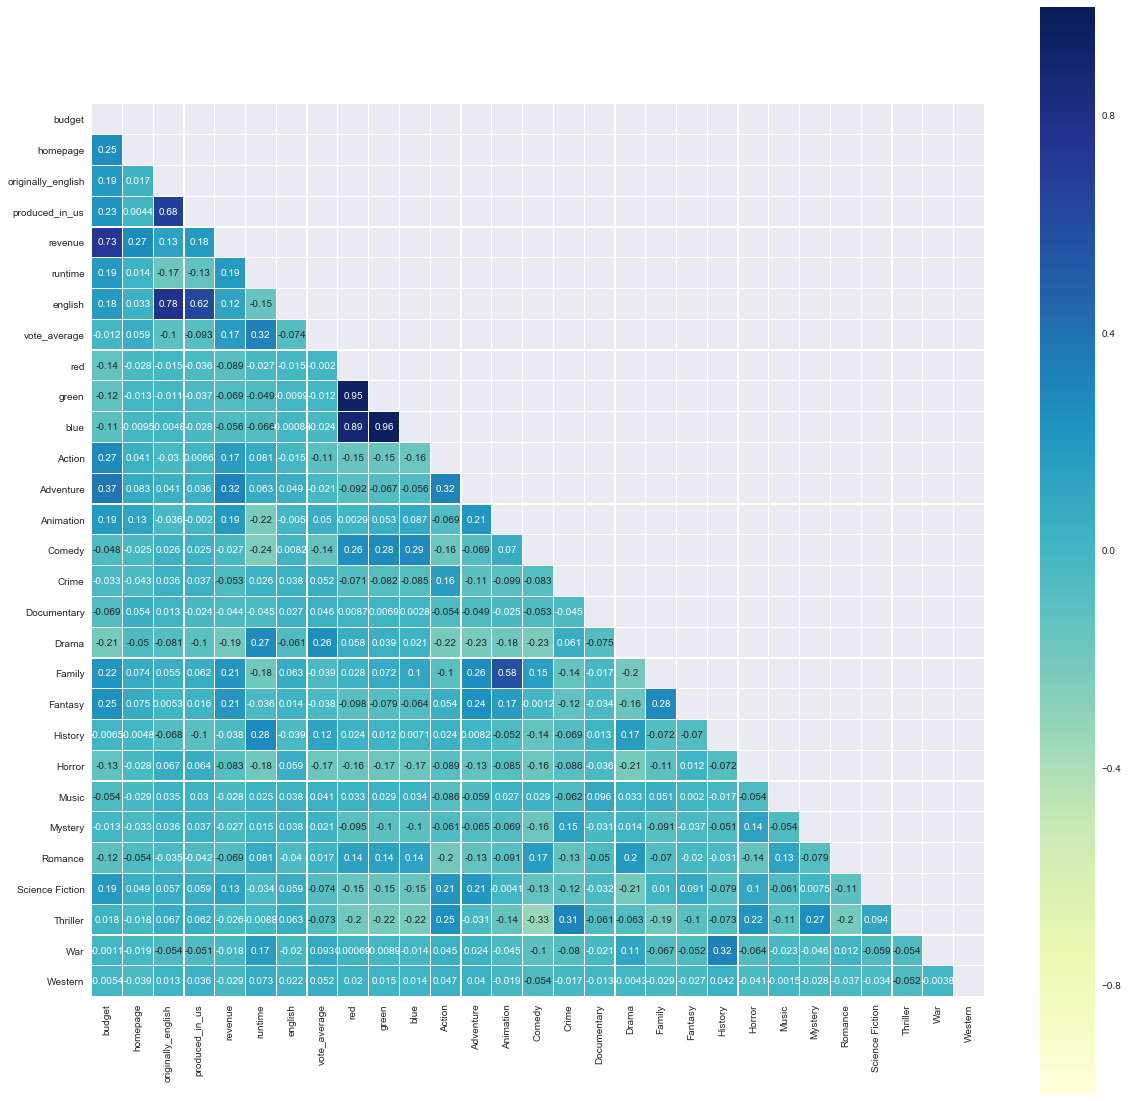

In [114]:
# A quick heatmap.
corr = movie_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20, 20))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=True, linewidths=0.2, center=0, cmap="YlGnBu")

In [115]:
makeCSV(movie_df, 'basic_df.csv')

## Posters

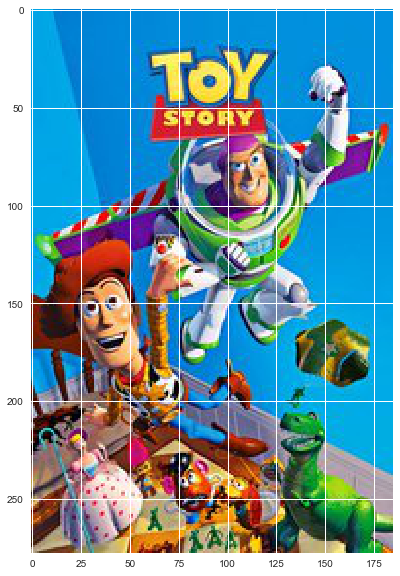

In [116]:
image = get_image(movie_df.loc[862, 'poster_path'])
imshow(image)
plt.show()

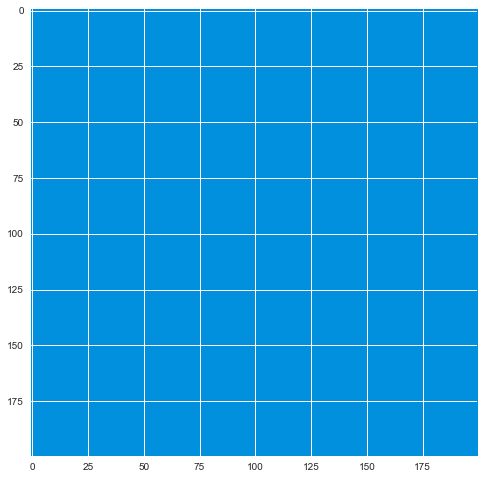

In [117]:
sample_color = print_color(862)
# Look at that, the conversion from poster most frequent color
# to columns of RGB worked.
# This is the most frequent color in the poster for Toy Story

In [118]:
# To save a color
color = get_color(862)
image = Image.new("RGB", (200, 200,), color)
image.save('color_toy_story.png')

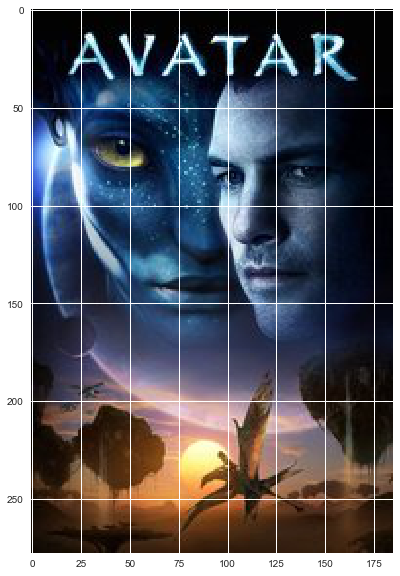

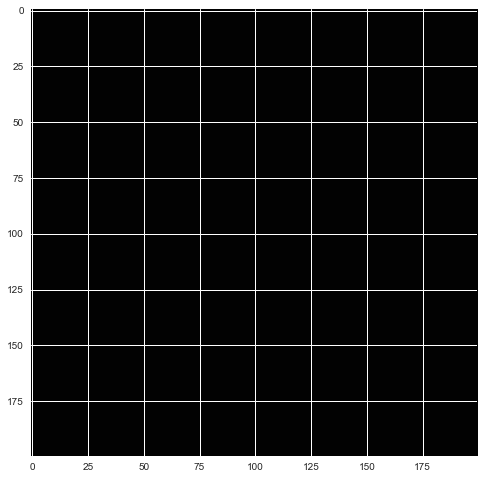

(2, 2, 2)


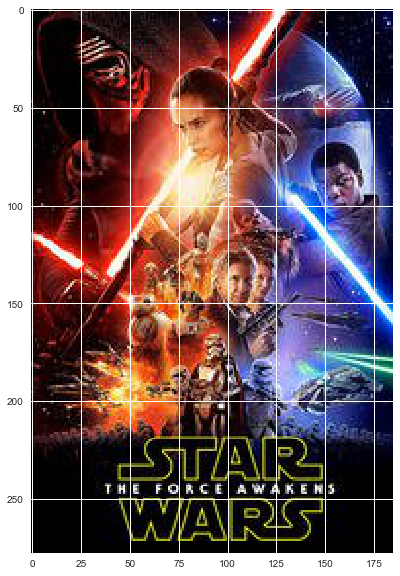

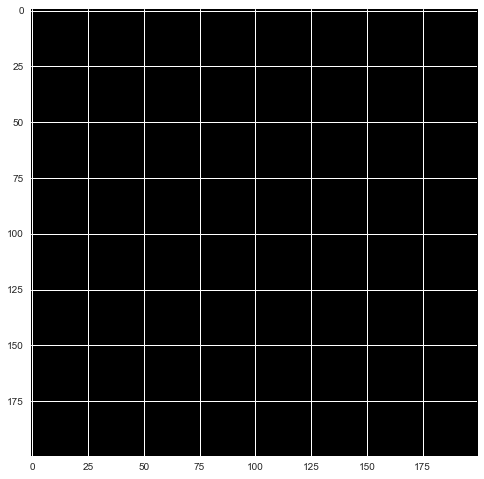

(0, 0, 0)


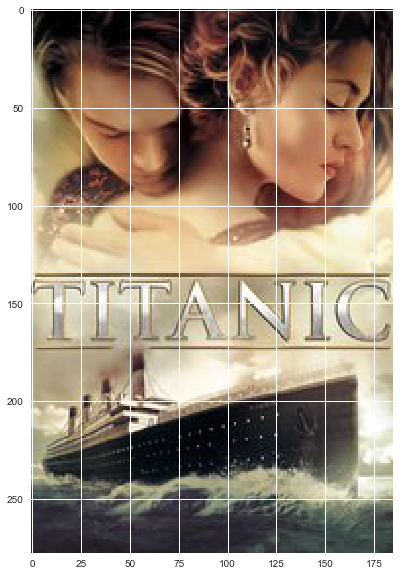

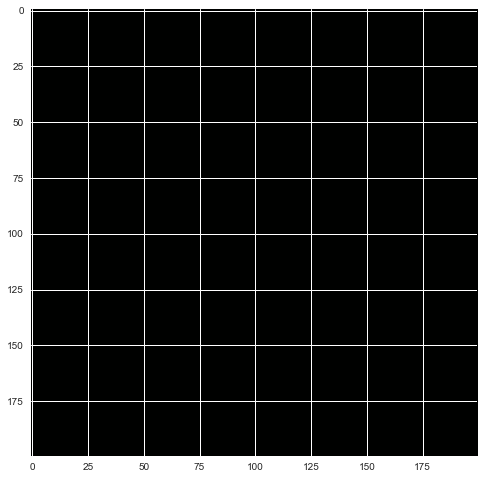

(0, 1, 0)


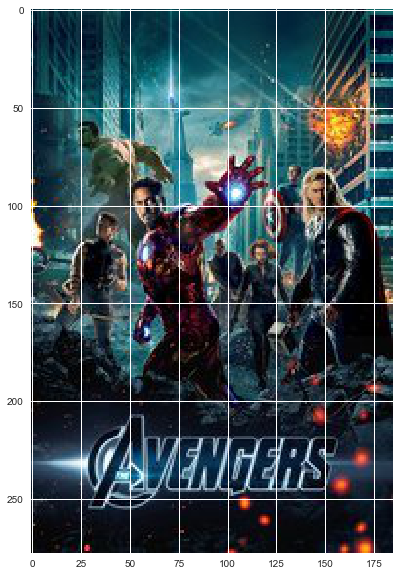

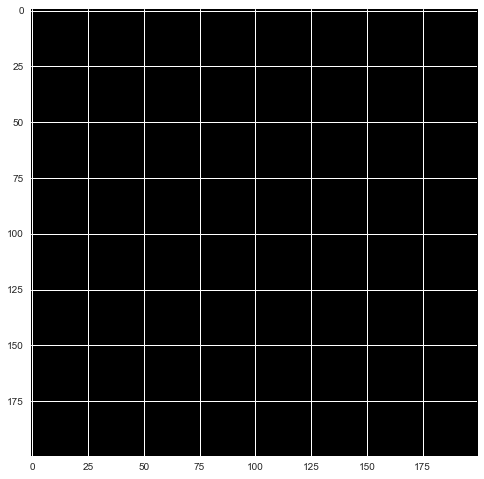

(0, 0, 0)


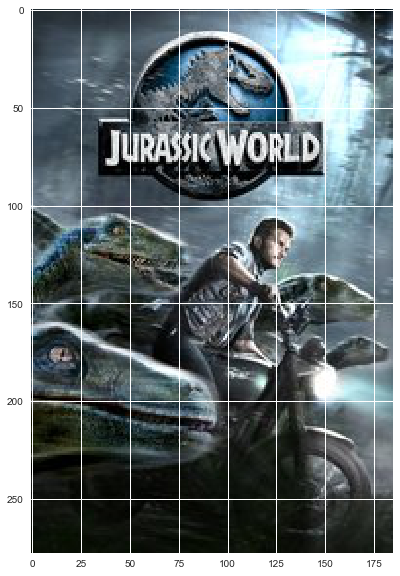

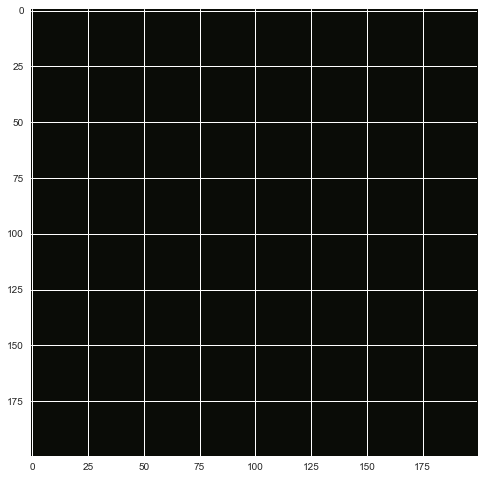

(10, 12, 7)


In [119]:
for index, row in movie_df.nlargest(5, 'revenue').iterrows():
    image = get_image(row['poster_path'])
    imshow(image)
    plt.show()
    color = print_color(index)
    print(color)

In [20]:
backup = movie_df

## Not Posters

In [201]:
movie_df = backup

In [202]:
# Function to truncate a list to the first 3 elements
def trunc_billing(cast):
    if len(cast) < 3:
        return cast
    else:
        return cast[0:3]
    
# Function to remove all duplicates from a list while retaining order.
def remove_dups(mylist):
    return sorted(set(mylist), key=lambda x: mylist.index(x))

def prep(mylist):
    mylist = remove_dups(mylist)
    return trunc_billing(mylist)

In [203]:
## Truncate the the top 3 billed actors and crew. Cast order matches Wikipedia, not sure what order it is though.
movie_df['cast'] = movie_df['cast'].apply(prep)
movie_df['crew'] = movie_df['crew'].apply(prep)

## Drop poster path
movie_df = movie_df.drop('poster_path', axis = 1)

In [204]:
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'], format = '%m/%d/%Y', errors='coerce')
# Convert release dates to Gregorian ordinal format
movie_df['release_date'] = movie_df['release_date'].apply(pd.Timestamp.toordinal)

In [205]:
# Make belongs_to_collection the size of the franchise, there are too many to deal with
zerocount = movie_df['belongs_to_collection'].value_counts()[0]
movie_df['belongs_to_collection'] = movie_df['belongs_to_collection'].map(movie_df['belongs_to_collection'].value_counts())
movie_df.loc[movie_df['belongs_to_collection'] == zerocount, 'belongs_to_collection'] = 0

In [206]:
# Take care of NaNs generated by the get_dummies functions
for column in movie_df.columns:
    movie_df[column].fillna(0, inplace=True)
movie_df.loc[:,'Action':] = movie_df.loc[:,'Action':].astype(np.int64)

In [207]:
actors = []
num_movies = []
revenue_avg = []
for index, row in movie_df.iterrows():
    cast = row['cast']
    revenue = row['revenue']
    for person in cast:
        try:
            index = actors.index(person)
        except:
            index = -1
        if(index != -1):
            temp = revenue_avg[index] * num_movies[index]
            temp += revenue
            num_movies[index] += 1
            revenue_avg[index] = temp/num_movies[index]
        else:
            actors.append(person)
            num_movies.append(1)
            revenue_avg.append(revenue)
print("Done")

Done


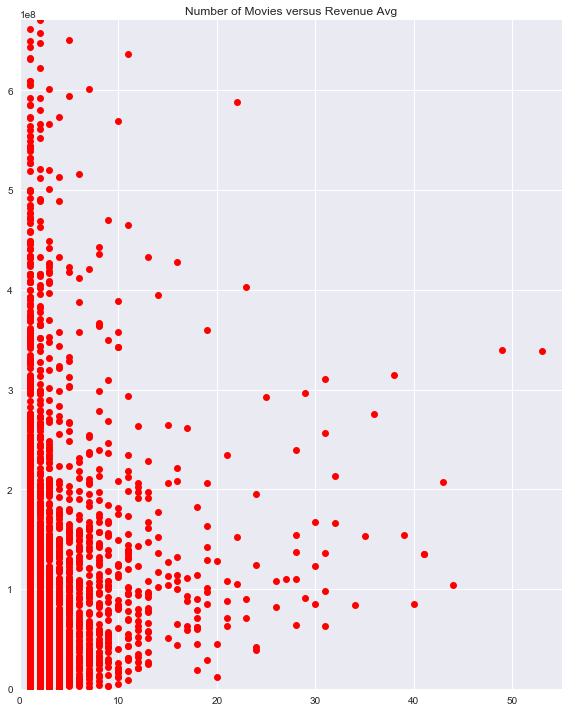

In [255]:
plt.plot(num_movies,revenue_avg, 'ro')
plt.title("Number of Movies versus Revenue Avg")
plt.axis([0,55,0,670000000])
plt.tight_layout()
plt.savefig('test_actors.png')

In [209]:
bad_act = []
solid_act = []
good_act = []
fluke_act = []
for i in range(0,len(revenue_avg)):
    if(revenue_avg[i] < 1000000):
        bad_act.append(actors[i])
    elif(((-10000000)*num_movies[i] + 50000000) > revenue_avg[i]):
        bad_act.append(actors[i])
    elif(num_movies[i] < 2):
        fluke_act.append(actors[i])
    elif(((-10000000)*num_movies[i] + 150000000) > revenue_avg[i]):
        solid_act.append(actors[i])
    else:
        good_act.append(actors[i])

In [210]:
print len(fluke_act)
print len(bad_act)
print len(solid_act)
print len(good_act)

1041
3369
1000
713


In [211]:
crew = []
num_movies = []
revenue_avg = []
for index, row in movie_df.iterrows():
    cast = row['crew']
    revenue = row['revenue']
    for person in cast:
        try:
            index = crew.index(person)
        except:
            index = -1
        if(index != -1):
            temp = revenue_avg[index] * num_movies[index]
            temp += revenue
            num_movies[index] += 1
            revenue_avg[index] = temp/num_movies[index]
        else:
            crew.append(person)
            num_movies.append(1)
            revenue_avg.append(revenue)
print("Done")

Done


In [212]:
print len(fluke_cre)
print len(bad_cre)
print len(solid_cre)
print len(good_cre)

1372
4008
1089
737


In [213]:
bad_cre = []
solid_cre = []
good_cre = []
fluke_cre = []
for i in range(0,len(revenue_avg)):
    if(revenue_avg[i] < 1000000):
        bad_cre.append(crew[i])
    elif(((-10000000)*num_movies[i] + 50000000) > revenue_avg[i]):
        bad_cre.append(crew[i])
    elif(num_movies[i] < 2):
        fluke_cre.append(crew[i])
    elif(((-10000000)*num_movies[i] + 150000000) > revenue_avg[i]):
        solid_cre.append(crew[i])
    else:
        good_cre.append(crew[i])

In [214]:
def intersect_fluke(a):
    return len(list( set(a) & set(fluke_act)))
def intersect_bad(a):
    return len(list( set(a) & set(bad_act)))
def intersect_solid(a):
    return len(list( set(a) & set(solid_act)))
def intersect_good(a):
    return len(list( set(a) & set(good_act)))
def intersect_fluke_cre(a):
    return len(list( set(a) & set(fluke_cre)))
def intersect_bad_cre(a):
    return len(list( set(a) & set(bad_cre)))
def intersect_solid_cre(a):
    return len(list( set(a) & set(solid_cre)))
def intersect_good_cre(a):
    return len(list( set(a) & set(good_cre)))

#### One Hot Encoding Options

In [215]:
## ONE HOT ENCODE PRODUCTION COMPANIES ##
test = pd.get_dummies(movie_df['production_companies'].apply(pd.Series).stack()).sum(level=0)
print("New Features:", test.shape)
dropping = []
for col in test.columns:
    if test[col].sum() < 45:
        dropping.append(col)
test = test.drop(dropping, axis=1)
print("Remaining at the cutoff of 45 or more: ", test.shape)
#print(test.columns)

('New Features:', (5184, 5430))
('Remaining at the cutoff of 45 or more: ', (5184, 27))


In [216]:
## MERGE TEST INTO MOVIE_DF
print(movie_df.shape)
movie_df = pd.concat((movie_df, test), axis = 1)
movie_df = movie_df.drop('production_companies', axis = 1)
print(movie_df.shape)

(5432, 38)
(5432, 64)


In [217]:
## ONE HOT ENCODE ACTORS ##
test = pd.get_dummies(movie_df['cast'].apply(pd.Series).stack()).sum(level=0)
print("New Features:", test.shape)
dropping = []
for col in test.columns:
    if test[col].sum() < 5:
        dropping.append(col)
# 6132 one-hot encoded actors.
# Drop it to those that have been in 5+ movies, bringing us to 789 one-hot encoded actors.
test = test.drop(dropping, axis=1)
print("One-hot encoded actors (5+ movies) by movie id:", test.shape)
#print(test.columns)

('New Features:', (5341, 6123))
('One-hot encoded actors (5+ movies) by movie id:', (5341, 788))


In [218]:
## MERGE TEST INTO MOVIE_DF
#movie_df = pd.concat((movie_df, test), axis = 1)
#movie_df = movie_df.drop('cast', axis = 1)
#print(movie_df.shape)

In [219]:
# Take care of NaNs generated by the get_dummies functions
for column in movie_df.columns:
    movie_df[column].fillna(0, inplace=True)
movie_df.loc[:,'Action':] = movie_df.loc[:,'Action':].astype(np.int64)

In [220]:
# Clean up weird non-binary values in binary features
for col in movie_df.columns[20:]:
    movie_df[col].fillna(0, inplace=True)
    movie_df.loc[movie_df[col] > 1, col] = 1

In [221]:
movie_df['cast_fluke'] = movie_df['cast'].apply(intersect_fluke)
movie_df['cast_bad'] = movie_df['cast'].apply(intersect_bad)
movie_df['cast_solid'] = movie_df['cast'].apply(intersect_solid)
movie_df['cast_good'] = movie_df['cast'].apply(intersect_good)
movie_df['crew_fluke'] = movie_df['crew'].apply(intersect_fluke_cre)
movie_df['crew_bad'] = movie_df['crew'].apply(intersect_bad_cre)
movie_df['crew_solid'] = movie_df['crew'].apply(intersect_solid_cre)
movie_df['crew_good'] = movie_df['crew'].apply(intersect_good_cre)

In [222]:
movie_df.head(8).transpose()
# Issues for modeling:
# overview, tagline, and title are all strings
# keywords, cast, and crew are lists

id,5,11,12,13,14,15,16,18
belongs_to_collection,0,8,2,0,0,0,2,0
budget,4000000,11000000,94000000,55000000,15000000,839727,12800000,90000000
homepage,0,1,1,0,1,0,0,0
originally_english,1,1,1,1,1,1,1,1
overview,It's Ted the Bellhop's first night on the job....,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in...","Newspaper magnate, Charles Foster Kane is take...","Selma, a Czech immigrant on the verge of blind...","In 2257, a taxi driver is unintentionally give..."
produced_in_us,1,1,1,1,1,1,1,0
release_date,728636,721864,731365,728115,730012,708690,730257,729151
revenue,4.3e+06,7.75398e+08,9.40336e+08,6.77945e+08,3.56297e+08,2.32177e+07,4.00319e+07,2.6392e+08
runtime,98,121,100,142,122,119,140,126
english,1,1,1,1,1,1,1,1


In [223]:
movie_df = movie_df.drop('cast', axis=1)
movie_df = movie_df.drop('crew', axis=1)

In [224]:
makeCSV(movie_df, 'colors.csv')

## Initial Models  

I'm just going to put the modeling helper functions I made for the midterm here for now.

In [225]:
from sklearn.model_selection import train_test_split

toy_df = movie_df.loc[movie_df['title'] == 'Toy Story']
revenue_toy = toy_df['revenue']
vote_toy = toy_df['vote_average']
toy_df = toy_df.drop(['revenue', 'vote_average'], axis=1)
## TEMP ITEM ##
toy_df = toy_df.drop(['overview', 'tagline', 'title', 'keywords'], axis=1)

revenue_df = movie_df['revenue']
vote_df = movie_df['vote_average']
df = movie_df.drop(['revenue', 'vote_average'], axis=1)
## TEMP ITEM ##
df = df.drop(['overview', 'tagline', 'title', 'keywords'], axis=1)

train_df, test_data, revenue_df, test_revenue, vote_df, test_vote = train_test_split(df, revenue_df, vote_df, test_size=None, random_state=42)
print("Train: ", train_df.shape)
print("Test: ", test_data.shape)
print("Revenue: ", revenue_df.shape, test_revenue.shape)
print("Vote Average: ", vote_df.shape, test_vote.shape)

('Train: ', (4074, 64))
('Test: ', (1358, 64))
('Revenue: ', (4074L,), (1358L,))
('Vote Average: ', (4074L,), (1358L,))


In [226]:
from sklearn.model_selection import GridSearchCV

def getCSVR(prediction,filename):
    submission = pd.DataFrame({"id":test_revenue.index, "revenue":prediction})
    submission = submission[['id', 'revenue']]
    submission.to_csv(('./models/' + filename), index = False)

def getPredR(model, params, filename):
    cv = GridSearchCV(model, params, scoring='neg_mean_squared_error') #Scoring TBD
    cv.fit(train_df, revenue_df)
    print("in", filename, "best parameters:", cv.best_params_, "with score of", cv.best_score_)
    pred = cv.best_estimator_.predict(test_data)
    getCSVR(pred, filename)
    return pred

def getCSVV(prediction,filename):
    submission = pd.DataFrame({"id":test_vote.index, "vote_avg":prediction})
    submission = submission[['id', 'vote_avg']]
    submission.to_csv(('./models/' + filename), index = False)

def getPredV(model, params, filename):
    cv = GridSearchCV(model, params, scoring='neg_mean_squared_error') #Scoring TBD
    cv.fit(train_df, vote_df)
    print("in", filename, "best parameters:", cv.best_params_, "with score of", cv.best_score_)
    pred = cv.best_estimator_.predict(test_data)
    getCSVV(pred, filename)
    return pred

In [227]:
# After deciding what to do with the features, we essentially just make a ton of these with different models.
import xgboost as xgb

params = {
    #'max_depth': [4],
    'learning_rate': [0.01]
    #'n_estimators': [500],
}

prediction1 = getPredR(xgb.XGBRegressor(), params, 'xgb_pred.csv')
prediction2 = getPredV(xgb.XGBRegressor(), params, 'xgb_vote_pred.csv')

('in', 'xgb_pred.csv', 'best parameters:', {'learning_rate': 0.01}, 'with score of', -14301664158055084.0)
('in', 'xgb_vote_pred.csv', 'best parameters:', {'learning_rate': 0.01}, 'with score of', -5.1814933639193503)


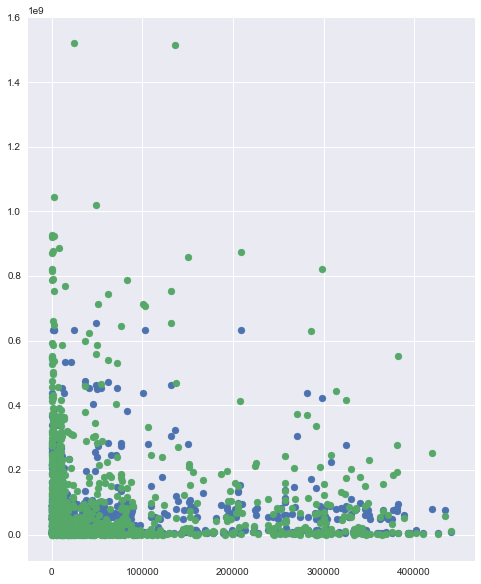

In [228]:
plt.scatter(test_revenue.index, prediction1)
plt.scatter(test_revenue.index, test_revenue)

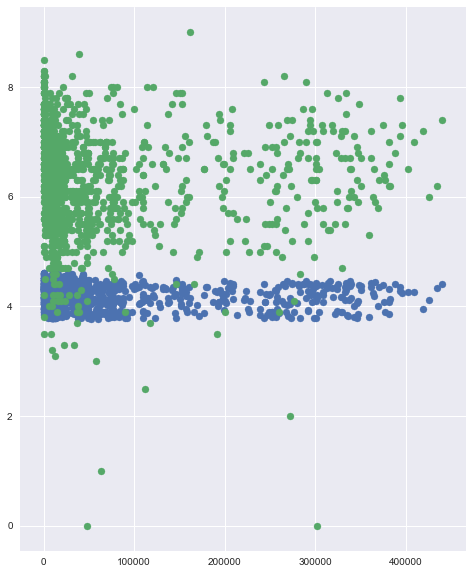

In [229]:
plt.scatter(test_vote.index, prediction2)
plt.scatter(test_vote.index, test_vote)

In [245]:
# After deciding what to do with the features, we essentially just make a ton of these with different models.
from sklearn.linear_model import Lasso

params = {
    'alpha': [1, 10, 100, 1000, 10000, 100000, 500000]
}

prediction = getPredR(Lasso(), params, 'lasso_pred.csv')
prediction2 = getPredV(Lasso(), params, 'lasso_vote.csv')

('in', 'lasso_pred.csv', 'best parameters:', {'alpha': 100000}, 'with score of', -11492905796239526.0)
('in', 'lasso_vote.csv', 'best parameters:', {'alpha': 1}, 'with score of', -0.71701686759246819)


Lasso picked 54 variables and eliminated the other 10 variables


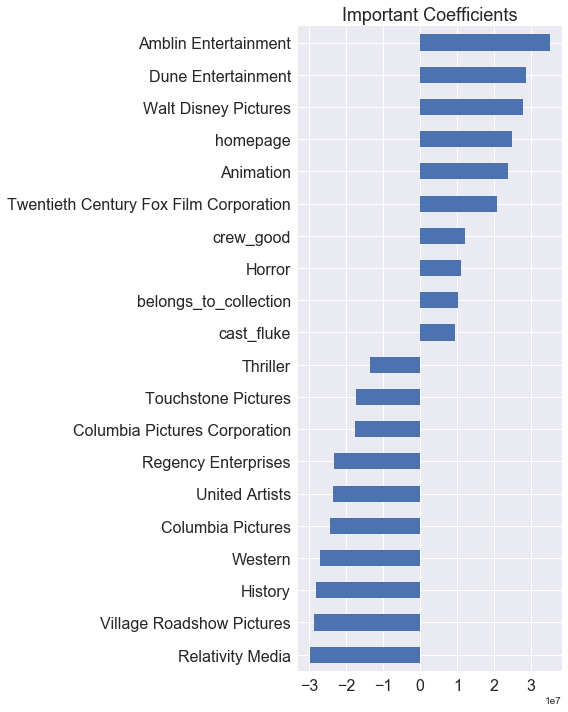

In [246]:
# From the housing regression Kaggle thing
lasso = Lasso(alpha = 100000)
lasso.fit(train_df, revenue_df)
coef = pd.Series(lasso.coef_, index = train_df.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
important_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef.plot(kind = "barh", fontsize=16)
plt.title("Important Coefficients", fontsize=18)
plt.tight_layout()
plt.savefig('test.png')

In [247]:
print(coef)
# red in a poster doesn't matter to Lasso

belongs_to_collection                     1.007013e+07
budget                                    2.464592e+00
homepage                                  2.473045e+07
originally_english                       -4.845823e+06
produced_in_us                           -0.000000e+00
release_date                             -2.168080e+03
runtime                                   6.267156e+05
english                                  -1.207863e+07
red                                       1.212365e+04
green                                     3.941255e+04
blue                                     -2.121472e+04
Action                                   -7.451317e+06
Adventure                                -3.624037e+06
Animation                                 2.374274e+07
Comedy                                   -7.109049e+05
Crime                                    -3.689068e+06
Documentary                               0.000000e+00
Drama                                    -4.767260e+06
Family    

In [253]:
print(lasso.predict(toy_df))
toy_df['green'] = 255
toy_df['red'] = 1
print(lasso.predict(toy_df))

color = tuple([int(toy_df.loc[862,'red']), int(toy_df.loc[862,'green']), int(toy_df.loc[862,'blue'])])
print(color)
image = Image.new("RGB", (200, 200,), color)
image.save('color_toy_story_alt.png')
print revenue_toy

[  2.11300779e+08]
[  2.08621452e+08]
(1, 255, 222)
id
862    373554033.0
Name: revenue, dtype: float64


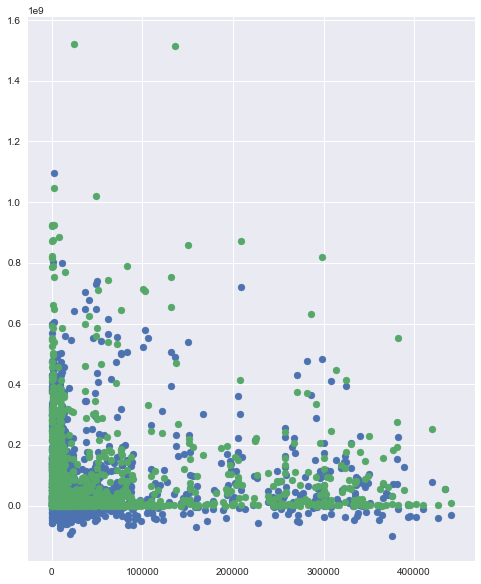

In [252]:
plt.scatter(test_revenue.index, prediction)
plt.scatter(test_revenue.index, test_revenue)

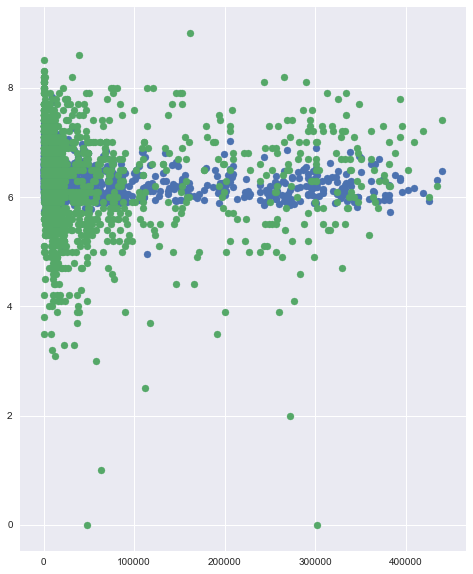

In [235]:
plt.scatter(test_vote.index, prediction2)
plt.scatter(test_vote.index, test_vote)

In [237]:
from sklearn.linear_model import Ridge

params = {
    'alpha': [53, 53.5, 54]
}

prediction = getPredR(Ridge(), params, 'ridge_pred.csv')
prediction2 = getPredV(Ridge(), params, 'ridge_vote.csv')

('in', 'ridge_pred.csv', 'best parameters:', {'alpha': 54}, 'with score of', -11440365290468952.0)
('in', 'ridge_vote.csv', 'best parameters:', {'alpha': 53}, 'with score of', -0.61138170690033178)


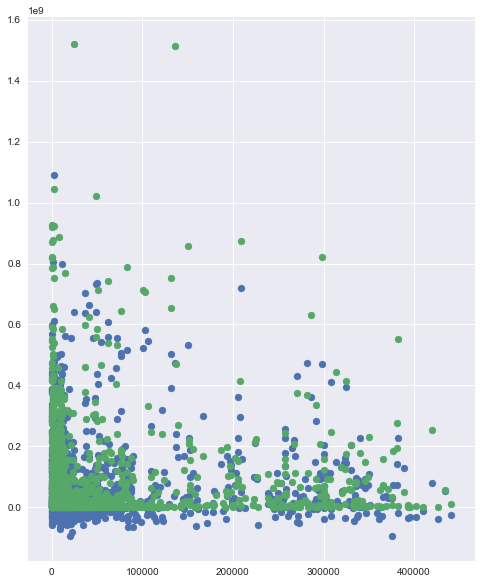

In [241]:
plt.scatter(test_revenue.index, prediction)
plt.scatter(test_revenue.index, test_revenue)

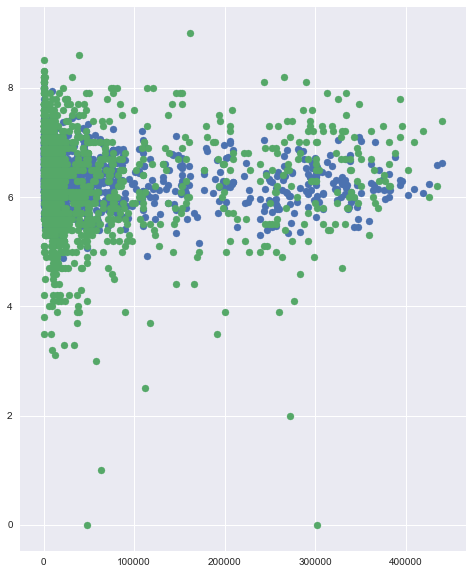

In [239]:
plt.scatter(test_vote.index, prediction2)
plt.scatter(test_vote.index, test_vote)

Ridge picked 64 variables and eliminated the other 0 variables


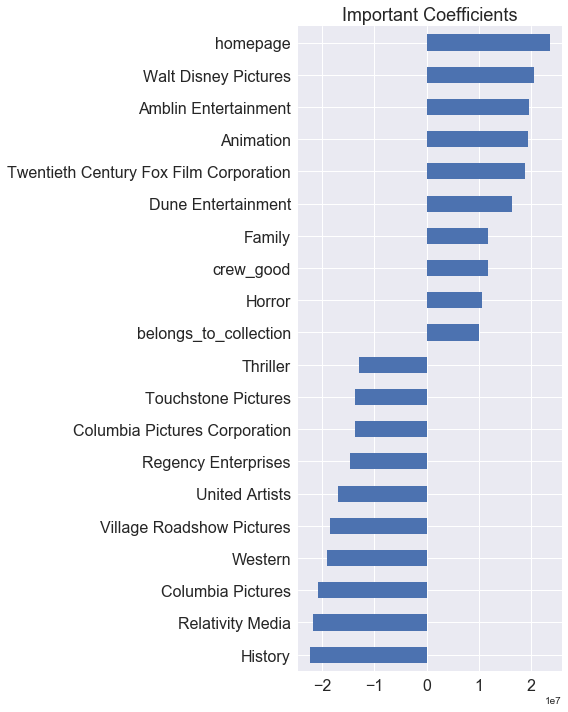

In [249]:
# From the housing regression Kaggle thing
ridge = Ridge(alpha = 53)
ridge.fit(train_df, revenue_df)
coef = pd.Series(ridge.coef_, index = train_df.columns)
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
important_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef.plot(kind = "barh", fontsize=16)
plt.title("Important Coefficients", fontsize=18)
plt.tight_layout()
plt.savefig('test_rid.png')

In [250]:
print (coef)

belongs_to_collection                     1.006383e+07
budget                                    2.478270e+00
homepage                                  2.360316e+07
originally_english                       -6.339553e+06
produced_in_us                            2.241424e+04
release_date                             -2.129589e+03
runtime                                   6.004591e+05
english                                  -1.091926e+07
red                                       8.547549e+03
green                                     4.448528e+04
blue                                     -2.280570e+04
Action                                   -8.144585e+06
Adventure                                -3.475758e+06
Animation                                 1.939704e+07
Comedy                                   -1.264092e+06
Crime                                    -3.996090e+06
Documentary                               4.407008e+06
Drama                                    -5.238428e+06
Family    